# VAE Training and Quality Assessment

This notebook focuses on training a Variational Autoencoder (VAE) and assessing its quality using the MNIST dataset. All underlying functions and classes are defined in `adversarial_vae_attack.py`.

## Overview
- **Training**: Train the VAE model with configurable parameters
- **Quality Assessment**: Evaluate model performance through various metrics
- **Visualization**: Plot training progress and latent space representations

In [6]:
# Auto-reload modules to get latest changes
%load_ext autoreload
%autoreload 2

# Clear any existing model to force reinitialization with fixed architecture
import gc
gc.collect()
if 'model' in globals():
    del model
print("Cleared previous model and enabled autoreload")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cleared previous model and enabled autoreload


In [7]:
# Import necessary libraries and functions from adversarial_vae_attack.py
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Import all classes and functions from our module
from adversarial_vae_attack import (
    VAE, 
    vae_loss, 
    train_vae, 
    get_mnist_loaders, 
    get_device,
    plot_latent_space,
    save_model,
    load_model
)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Imports successful!
PyTorch version: 2.5.1
CUDA available: False


In [8]:
# Configuration and Data Loading
# Set device
device = get_device()

# Training configuration
CONFIG = {
    'latent_dim': 2,
    'epochs': 20,
    'learning_rate': 1e-3,
    'beta': 1.0,  # KL divergence weight
    'batch_size_train': 128,
    'batch_size_test': 64,
    'data_dir': './data'
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Load MNIST dataset
print("\nLoading MNIST dataset...")
train_loader, test_loader = get_mnist_loaders(
    batch_size_train=CONFIG['batch_size_train'],
    batch_size_test=CONFIG['batch_size_test'],
    data_dir=CONFIG['data_dir']
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Using device: mps
Configuration:
  latent_dim: 2
  epochs: 20
  learning_rate: 0.001
  beta: 1.0
  batch_size_train: 128
  batch_size_test: 64
  data_dir: ./data

Loading MNIST dataset...
Training samples: 60000
Test samples: 10000
Training batches: 469
Test batches: 157


In [9]:
# Model Initialization
# Initialize VAE model
model = VAE(latent_dim=CONFIG['latent_dim'])
model.to(device)

print("VAE Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Display a sample from the dataset
sample_batch, sample_labels = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch.shape}")
print(f"Sample labels shape: {sample_labels.shape}")
print(f"Data range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

VAE Model Architecture:
VAE(
  (encoder): LeNetEncoder(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc_mu): Linear(in_features=84, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=84, out_features=2, bias=True)
  )
  (decoder): LeNetDecoder(
    (fc1): Linear(in_features=2, out_features=84, bias=True)
    (fc2): Linear(in_features=84, out_features=120, bias=True)
    (fc3): Linear(in_features=120, out_features=400, bias=True)
    (deconv1): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(6, 6, kern

## Training Phase

Now we'll train the VAE model using the configured parameters. The training function handles the optimization loop and tracks the loss over epochs.

In [10]:
# Train the VAE model
print("Starting VAE training...")
print(f"Training for {CONFIG['epochs']} epochs with lr={CONFIG['learning_rate']}, beta={CONFIG['beta']}")

train_losses = train_vae(
    model=model,
    train_loader=train_loader,
    epochs=CONFIG['epochs'],
    lr=CONFIG['learning_rate'],
    beta=CONFIG['beta']
)

print(f"\nTraining completed!")
print(f"Final training loss: {train_losses[-1]:.6f}")

# Save the trained model
model_path = "trained_vae_model.pth"
save_model(model, model_path)

Starting VAE training...
Training for 20 epochs with lr=0.001, beta=1.0
Training VAE...


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:23<07:28, 23.58s/it]

Epoch 0, Average Loss: 235.8809


 30%|███       | 6/20 [02:19<05:25, 23.22s/it]

Epoch 5, Average Loss: 155.3162


 55%|█████▌    | 11/20 [30:59<28:47, 191.90s/it] 

Epoch 10, Average Loss: 149.9376


 80%|████████  | 16/20 [33:03<03:29, 52.36s/it] 

Epoch 15, Average Loss: 147.0050


100%|██████████| 20/20 [34:47<00:00, 104.36s/it]


Training completed!
Final training loss: 145.619244
Model saved to trained_vae_model.pth


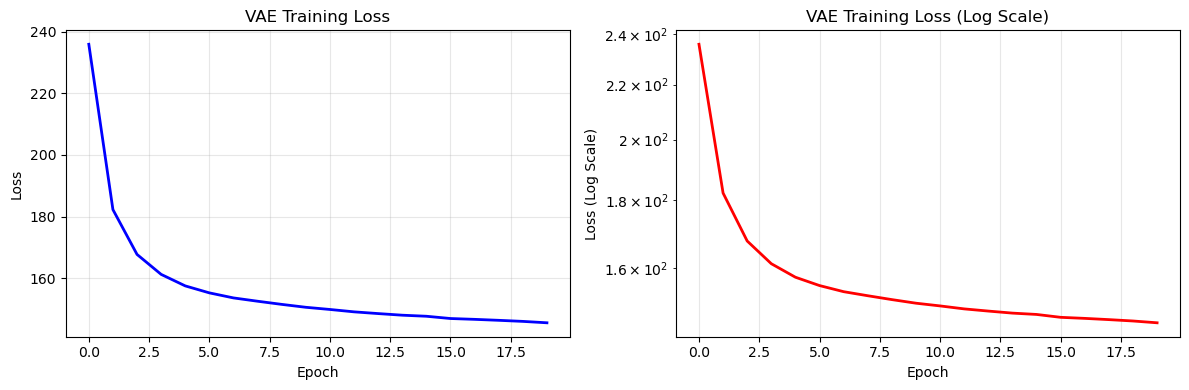

Loss decreased from 235.880914 to 145.619244
Total reduction: 38.27%


In [11]:
# Visualize training progress
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Plot loss on log scale for better visibility
plt.subplot(1, 2, 2)
plt.semilogy(train_losses, 'r-', linewidth=2)
plt.title('VAE Training Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Loss decreased from {train_losses[0]:.6f} to {train_losses[-1]:.6f}")
print(f"Total reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")

## Quality Assessment

Now we'll evaluate the quality of our trained VAE through various metrics and visualizations:

1. **Latent Space Visualization**: See how the model organizes different digits in the 2D latent space
2. **Reconstruction Quality**: Compare original images with their reconstructions
3. **Generation Quality**: Sample new images from the latent space
4. **Quantitative Metrics**: Calculate reconstruction errors and other quality measures

In [15]:
# Fix device handling for MPS compatibility
# Reload the device function and ensure model is properly on device
from adversarial_vae_attack import get_device

# Get the corrected device object
device = get_device()

# Ensure model is properly moved to device with all parameters
model = model.to(device)

# Verify device assignment
print(f"Model device: {next(model.parameters()).device}")
print(f"Device object type: {type(device)}")

# Test a small forward pass to ensure everything works
with torch.no_grad():
    test_sample = next(iter(test_loader))[0][:1].to(device)
    test_output = model(test_sample)
    print(f"Test forward pass successful! Output shape: {test_output[0].shape}")

Using device: mps
Model device: mps:0
Device object type: <class 'torch.device'>
Test forward pass successful! Output shape: torch.Size([1, 1, 28, 28])
Test forward pass successful! Output shape: torch.Size([1, 1, 28, 28])


Generating latent space visualization...


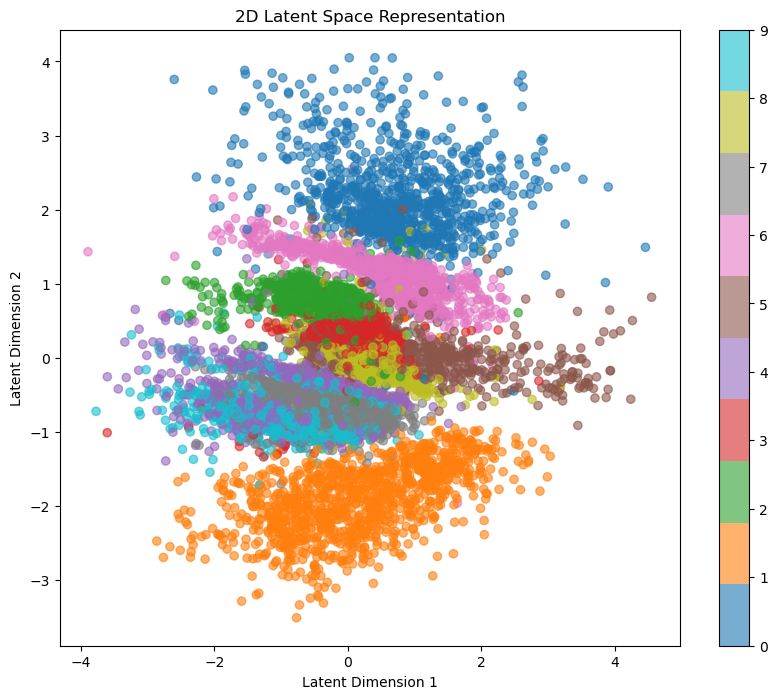

In [16]:
# 1. Visualize the latent space representation
print("Generating latent space visualization...")
plot_latent_space(model, test_loader, device)

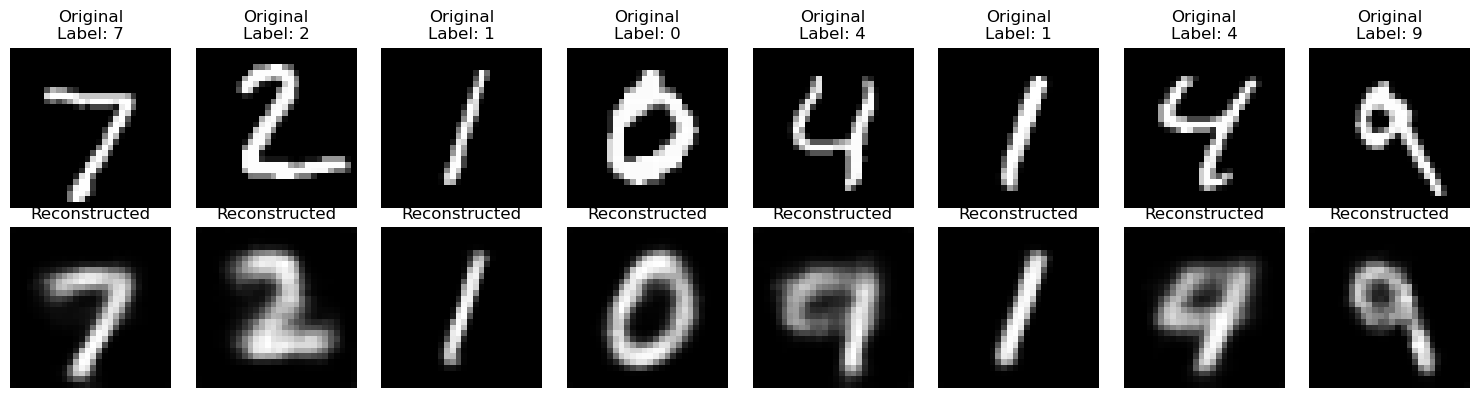

Average reconstruction MSE: 0.037165


In [17]:
# 2. Evaluate reconstruction quality
model.eval()

# Get test samples
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)
test_images = test_images.to(device)

# Generate reconstructions
with torch.no_grad():
    reconstructions, mu, logvar = model(test_images)

# Visualize original vs reconstructed images
n_samples = 8
fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))

for i in range(n_samples):
    # Original images
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title(f'Original\nLabel: {test_labels[i].item()}')
    axes[0, i].axis('off')
    
    # Reconstructed images
    axes[1, i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Calculate reconstruction error
recon_error = F.mse_loss(reconstructions, test_images).item()
print(f"Average reconstruction MSE: {recon_error:.6f}")

Generating new samples from latent space...


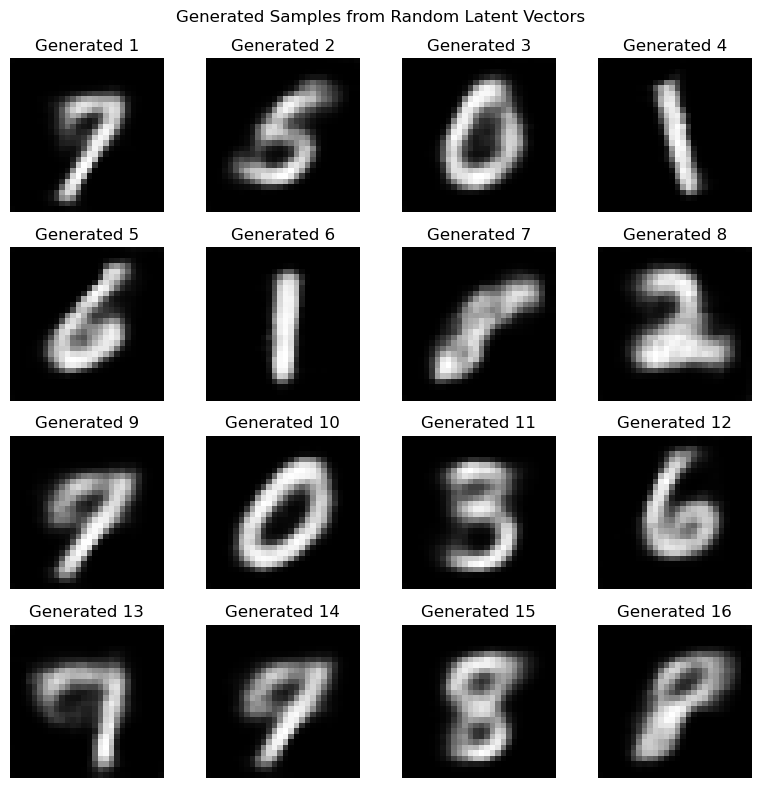

In [18]:
# 3. Generate new samples from random latent vectors
print("Generating new samples from latent space...")

# Sample random points in latent space
n_samples = 16
random_latent = torch.randn(n_samples, CONFIG['latent_dim']).to(device)

# Generate images
with torch.no_grad():
    generated_images = model.decode(random_latent)

# Visualize generated samples
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(n_samples):
    row, col = i // 4, i % 4
    axes[row, col].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    axes[row, col].set_title(f'Generated {i+1}')
    axes[row, col].axis('off')

plt.suptitle('Generated Samples from Random Latent Vectors')
plt.tight_layout()
plt.show()

Performing latent space interpolation...


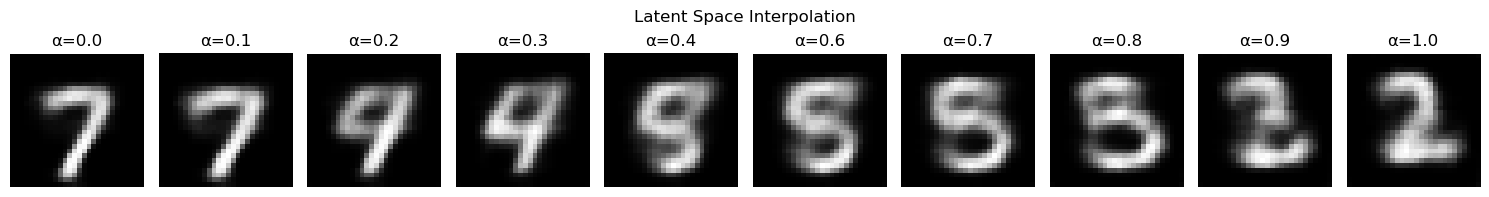

In [20]:
# 4. Latent space interpolation
print("Performing latent space interpolation...")

# Get two different samples
sample1 = test_images[0:1]  # First sample
sample2 = test_images[1:2]  # Second sample

# Encode to latent space
with torch.no_grad():
    mu1, _ = model.encoder(sample1)
    mu2, _ = model.encoder(sample2)

# Interpolate between the two latent representations
n_steps = 10
alphas = torch.linspace(0, 1, n_steps).to(device)

interpolated_images = []
for alpha in alphas:
    # Linear interpolation in latent space
    interpolated_z = (1 - alpha) * mu1 + alpha * mu2
    
    # Decode back to image space
    with torch.no_grad():
        interpolated_img = model.decode(interpolated_z)
    
    interpolated_images.append(interpolated_img)

# Visualize interpolation
fig, axes = plt.subplots(1, n_steps, figsize=(15, 2))
for i, img in enumerate(interpolated_images):
    axes[i].imshow(img[0].cpu().squeeze(), cmap='gray')
    axes[i].set_title(f'α={alphas[i]:.1f}')
    axes[i].axis('off')

plt.suptitle('Latent Space Interpolation')
plt.tight_layout()
plt.show()

In [19]:
# 5. Comprehensive quantitative assessment
print("Calculating comprehensive quality metrics...")

model.eval()
total_recon_loss = 0
total_kl_loss = 0
total_samples = 0

# Calculate metrics on test set
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
        
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_samples += data.size(0)

# Average losses
avg_recon_loss = total_recon_loss / total_samples
avg_kl_loss = total_kl_loss / total_samples
avg_total_loss = avg_recon_loss + CONFIG['beta'] * avg_kl_loss

print("\n" + "="*50)
print("QUALITY ASSESSMENT RESULTS")
print("="*50)
print(f"Average Reconstruction Loss: {avg_recon_loss:.6f}")
print(f"Average KL Divergence Loss:  {avg_kl_loss:.6f}")
print(f"Average Total Loss:          {avg_total_loss:.6f}")
print(f"Beta (KL weight):            {CONFIG['beta']}")
print(f"Latent Dimension:            {CONFIG['latent_dim']}")
print(f"Test Set Size:               {total_samples:,}")
print("="*50)

# Additional metrics
with torch.no_grad():
    # Sample a batch for additional metrics
    sample_data, _ = next(iter(test_loader))
    sample_data = sample_data.to(device)
    sample_recon, sample_mu, sample_logvar = model(sample_data)
    
    # MSE between original and reconstruction
    mse_loss = F.mse_loss(sample_recon, sample_data).item()
    
    # SSIM-like metric (simplified)
    # Mean and std of latent representations
    latent_mean = sample_mu.mean().item()
    latent_std = sample_mu.std().item()
    
    print(f"Sample MSE Loss:             {mse_loss:.6f}")
    print(f"Latent Mean:                 {latent_mean:.6f}")
    print(f"Latent Std:                  {latent_std:.6f}")
    print("="*50)

Calculating comprehensive quality metrics...

QUALITY ASSESSMENT RESULTS
Average Reconstruction Loss: 140.068254
Average KL Divergence Loss:  6.350017
Average Total Loss:          146.418270
Beta (KL weight):            1.0
Latent Dimension:            2
Test Set Size:               10,000
Sample MSE Loss:             0.037863
Latent Mean:                 -0.312937
Latent Std:                  1.117254

QUALITY ASSESSMENT RESULTS
Average Reconstruction Loss: 140.068254
Average KL Divergence Loss:  6.350017
Average Total Loss:          146.418270
Beta (KL weight):            1.0
Latent Dimension:            2
Test Set Size:               10,000
Sample MSE Loss:             0.037863
Latent Mean:                 -0.312937
Latent Std:                  1.117254


Creating latent space image grid...
Generated 625 latent points in a 25x25 grid
Latent range: [-3.0, 3.0]


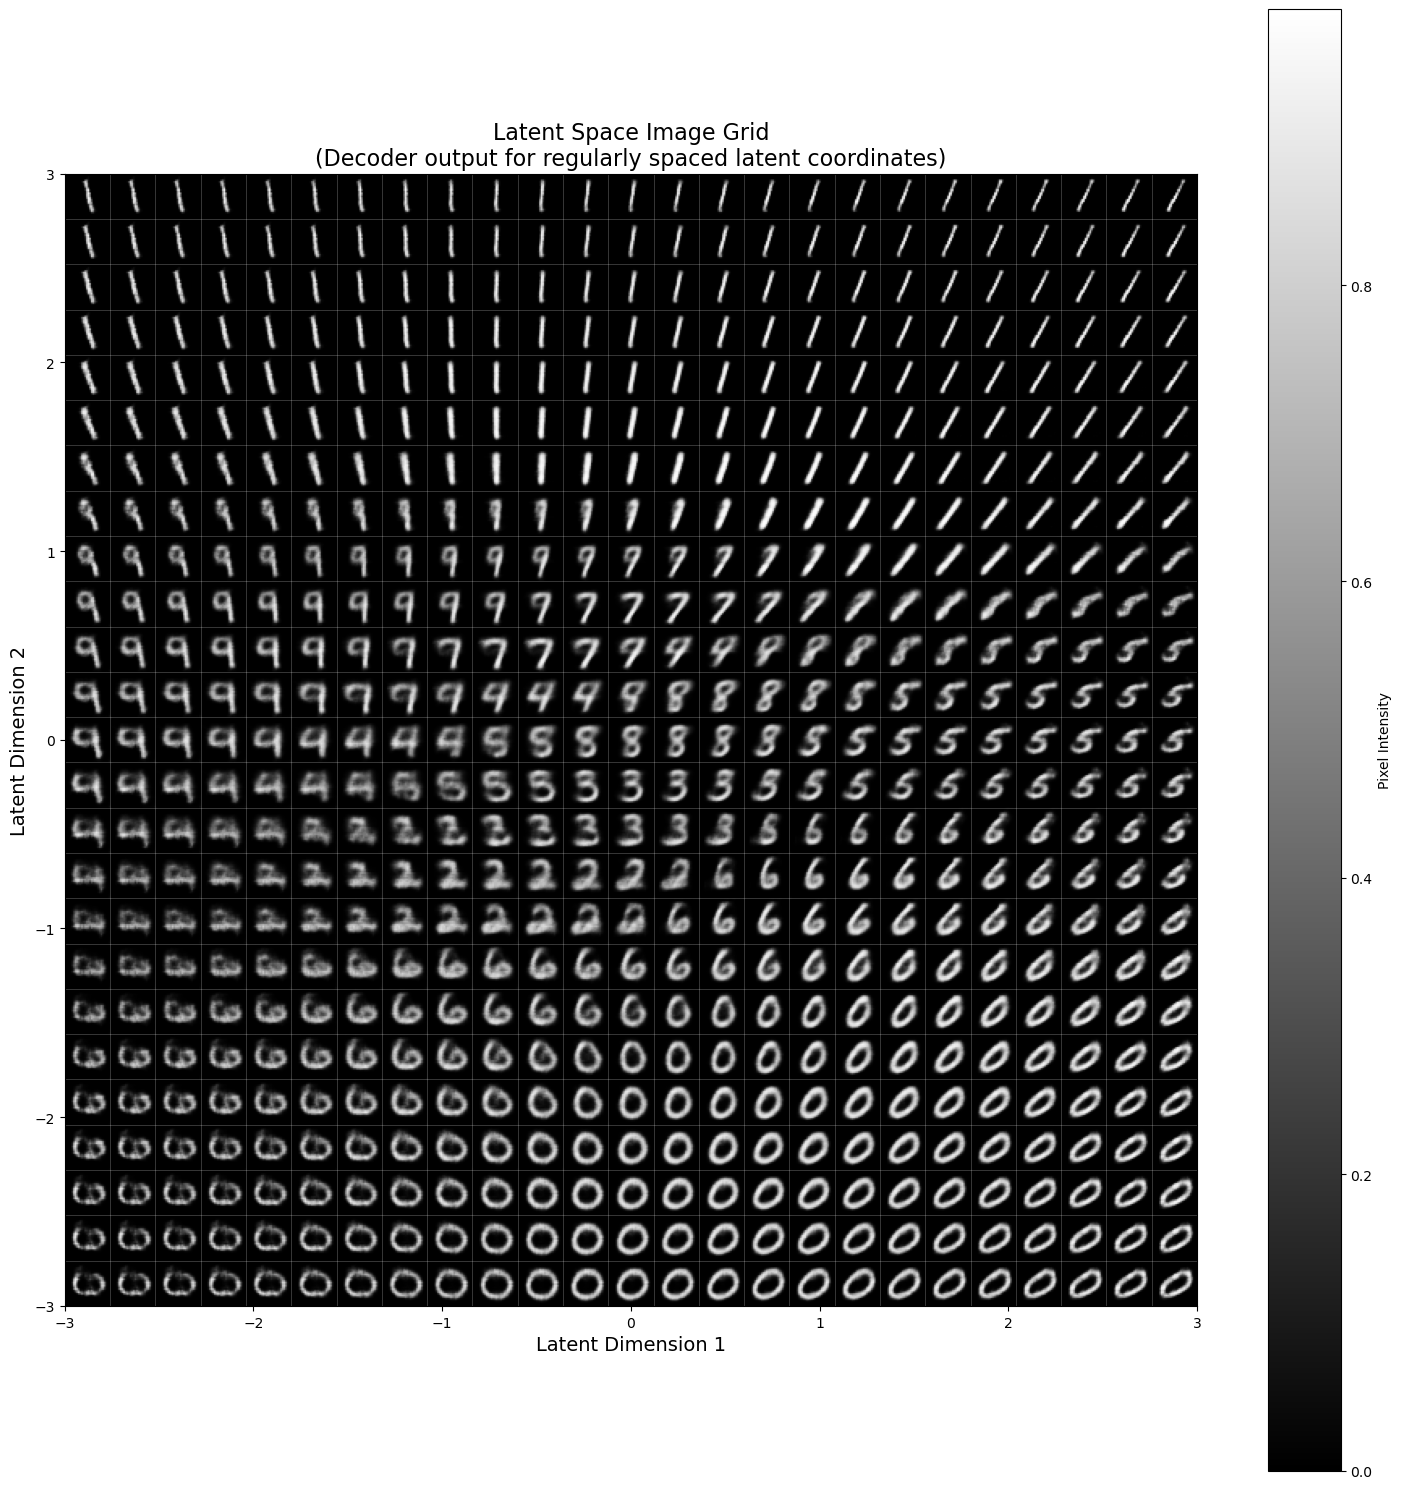

Latent space grid visualization complete!
Each cell in the grid shows what the decoder generates for that (x,y) latent coordinate
You can see how similar digits cluster together in the latent space


In [22]:
# 6. Latent Space Image Grid Visualization
print("Creating latent space image grid...")

# Create a grid of latent space coordinates
grid_size = 25  # 15x15 grid
latent_range = 3.0  # Range from -3 to +3 for both dimensions

# Create coordinate arrays
x = np.linspace(-latent_range, latent_range, grid_size)
y = np.linspace(-latent_range, latent_range, grid_size)

# Create meshgrid
xx, yy = np.meshgrid(x, y)

# Flatten and create latent coordinates
latent_coords = np.column_stack([xx.ravel(), yy.ravel()])
latent_tensor = torch.FloatTensor(latent_coords).to(device)

print(f"Generated {len(latent_coords)} latent points in a {grid_size}x{grid_size} grid")
print(f"Latent range: [{-latent_range:.1f}, {latent_range:.1f}]")

# Generate images from latent coordinates
model.eval()
with torch.no_grad():
    generated_grid = model.decode(latent_tensor)

# Reshape to grid format
generated_grid = generated_grid.cpu().numpy().reshape(grid_size, grid_size, 28, 28)

# Create the visualization
plt.figure(figsize=(15, 15))

# Create a large image by concatenating all generated images
full_image = np.zeros((grid_size * 28, grid_size * 28))

for i in range(grid_size):
    for j in range(grid_size):
        # Calculate position in the full image
        row_start = i * 28
        row_end = (i + 1) * 28
        col_start = j * 28
        col_end = (j + 1) * 28
        
        # Place the generated image
        full_image[row_start:row_end, col_start:col_end] = generated_grid[i, j]

# Display the full latent space grid
plt.imshow(full_image, cmap='gray', extent=[-latent_range, latent_range, -latent_range, latent_range])
plt.xlabel('Latent Dimension 1', fontsize=14)
plt.ylabel('Latent Dimension 2', fontsize=14)
plt.title('Latent Space Image Grid\n(Decoder output for regularly spaced latent coordinates)', fontsize=16)

# Add grid lines to separate individual images
for i in range(1, grid_size):
    coord = -latent_range + i * (2 * latent_range / grid_size)
    plt.axhline(y=coord, color='white', linewidth=0.5, alpha=0.3)
    plt.axvline(x=coord, color='white', linewidth=0.5, alpha=0.3)

plt.colorbar(label='Pixel Intensity')
plt.tight_layout()
plt.show()

print(f"Latent space grid visualization complete!")
print(f"Each cell in the grid shows what the decoder generates for that (x,y) latent coordinate")
print(f"You can see how similar digits cluster together in the latent space")

In [23]:
# 7. Save Model and Training Information
import os
import json
from datetime import datetime

def save_model_with_metadata(model, config, train_losses, notebook_dir=None):
    """
    Save the trained model with metadata in the same directory as the notebook
    
    Args:
        model: Trained VAE model
        config: Training configuration dictionary
        train_losses: List of training losses
        notebook_dir: Directory to save in (if None, uses current directory)
    """
    # Get notebook directory if not provided
    if notebook_dir is None:
        notebook_dir = os.path.dirname(os.path.abspath('vae_trainer1.ipynb'))
    
    # Create timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Define file paths
    model_filename = f"vae_model_{timestamp}.pth"
    metadata_filename = f"vae_metadata_{timestamp}.json"
    losses_filename = f"vae_losses_{timestamp}.json"
    
    model_path = os.path.join(notebook_dir, model_filename)
    metadata_path = os.path.join(notebook_dir, metadata_filename)
    losses_path = os.path.join(notebook_dir, losses_filename)
    
    # Save model state dict
    torch.save(model.state_dict(), model_path)
    
    # Prepare metadata
    metadata = {
        'timestamp': timestamp,
        'model_filename': model_filename,
        'config': config,
        'model_architecture': {
            'type': 'VAE',
            'latent_dim': config['latent_dim'],
            'total_parameters': sum(p.numel() for p in model.parameters()),
            'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
        },
        'training_info': {
            'final_loss': train_losses[-1] if train_losses else None,
            'initial_loss': train_losses[0] if train_losses else None,
            'total_epochs': len(train_losses),
            'loss_reduction_percent': ((train_losses[0] - train_losses[-1]) / train_losses[0] * 100) if train_losses else None
        },
        'device': str(device),
        'pytorch_version': torch.__version__
    }
    
    # Save metadata
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Save training losses
    losses_data = {
        'timestamp': timestamp,
        'losses': train_losses,
        'epochs': list(range(len(train_losses)))
    }
    
    with open(losses_path, 'w') as f:
        json.dump(losses_data, f, indent=2)
    
    print(f"Model and metadata saved successfully!")
    print(f"📁 Directory: {notebook_dir}")
    print(f"🔧 Model file: {model_filename}")
    print(f"📊 Metadata file: {metadata_filename}")
    print(f"📈 Losses file: {losses_filename}")
    
    return {
        'model_path': model_path,
        'metadata_path': metadata_path,
        'losses_path': losses_path,
        'timestamp': timestamp
    }

# Save the current trained model with all metadata
print("Saving trained VAE model with complete metadata...")
save_info = save_model_with_metadata(model, CONFIG, train_losses)

print(f"\n✅ Model successfully saved with timestamp: {save_info['timestamp']}")
print(f"You can load this model later using:")
print(f"model = VAE(latent_dim={CONFIG['latent_dim']})")
print(f"model.load_state_dict(torch.load('{save_info['model_path']}'))")

Saving trained VAE model with complete metadata...
Model and metadata saved successfully!
📁 Directory: /Users/pmaksym/Library/CloudStorage/Box-Box/Code/adversAE/adversae
🔧 Model file: vae_model_20250715_104503.pth
📊 Metadata file: vae_metadata_20250715_104503.json
📈 Losses file: vae_losses_20250715_104503.json

✅ Model successfully saved with timestamp: 20250715_104503
You can load this model later using:
model = VAE(latent_dim=2)
model.load_state_dict(torch.load('/Users/pmaksym/Library/CloudStorage/Box-Box/Code/adversAE/adversae/vae_model_20250715_104503.pth'))


## Summary

This notebook successfully demonstrated:

1. **VAE Training**: Trained a Variational Autoencoder on MNIST with configurable parameters
2. **Quality Assessment**: Evaluated the model through multiple metrics:
   - Training loss convergence
   - Latent space visualization and organization
   - Reconstruction quality comparison
   - Generation capability from random sampling
   - Smooth interpolation in latent space
   - Quantitative metrics (reconstruction loss, KL divergence, MSE)

### Key Takeaways:
- The VAE learned to organize digits in a meaningful 2D latent space
- Reconstruction quality demonstrates the model's ability to capture important features
- Generated samples show the model can create realistic digit-like images
- Latent space interpolation reveals smooth transitions between different representations

### Next Steps:
- The trained model can now be used for adversarial attack experiments
- Model parameters can be tuned for better performance
- Different beta values can be explored for β-VAE variants
- The model is saved and ready for further analysis